In [7]:
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
import pandas as pd
import seaborn as sns
import random


from InitializeSpeciesPool import *
from LV import *
from VariousMetrics import *

sns.set_style("ticks")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}



session_name="results/test"


# Function Definition

In [19]:
from scipy.integrate import odeint

'''

def gLV(y, t, I_simul, g_simul, k_simul):
    dydt = np.zeros_like(y)
    for i in range(len(y)):
        dydt[i] = g_simul[i]* y[i] * (1- np.sum(I_simul[i,:] * y)/k_simul[i])
    return dydt

def run_lotka_volterra_dynamics(y0, t, s_idx, I, g, k):
    
    s_idx=np.where(s_idx)[0].tolist()
    N=len(y0)
    y0_simul=y0[s_idx]
    I_simul=I[s_idx,:]
    I_simul=I_simul[:,s_idx]
    g_simul=g[s_idx]
    k_simul=k[s_idx]
    
    
    y = odeint(gLV, y0_simul, t, args=(I_simul, g_simul, k_simul))
    y_out=np.zeros(N)
    for i in range(y.shape[1]):
        y_out[s_idx[i]]=y[-1,i] 
    return y
'''
def gLV_env(y, t, beta, delta, migration_rate, I, g, k, p, q, varIdx):
    # p : species -> pH
    # q : pH -> species
    dydt = np.zeros(len(varIdx['env']) + len(varIdx['species']))
    
    growth_rate_multiplier = 1 - (np.matmul(I, y[varIdx['species']])) / k + np.matmul(q, y[varIdx['env']])
    
    dydt[varIdx['species']] = np.multiply(np.multiply(y[varIdx['species']], g), growth_rate_multiplier) + migration_rate #- death_rate * y[varIdx['species']]
    dydt[varIdx['env']] = delta * (-y[varIdx['env']]) + beta* np.matmul(p, y[varIdx['species']]) - 0.001 * y[varIdx['env']]**3
    
    return dydt

def run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=False):
    

    N=system_config['N']
    N_env=system_config['N_env']
    beta = system_config['beta']
    delta = system_config['delta']
    migration_rate = system_config['migration_rate']
    I = system_config['I']
    g = system_config['g']
    k = system_config['k']
    p = system_config['p']
    q = system_config['q']
                                   
    I=I[species_index,:]
    I=I[:,species_index]
    g=g[species_index]
    k=k[species_index]
    p=p[:,species_index] # p is N_env x N
    p=p[env_index,:]                               
    q=q[species_index,:] # q is N x N_Nev
    q=q[:,env_index]                             
    
    varIdx={'species' : np.arange(len(species_index)),
           'env' : np.arange(len(species_index),len(species_index)+len(env_index))}
    y0=np.concatenate((y0_species, y0_env))
    print(varIdx)
    print(y0)
    
    y = odeint(gLV_env, y0, t, args=(beta, delta, migration_rate, I, g, k, p, q, varIdx))
    y_out={}
    y_out_species=np.zeros(N)
    y_out_env=np.zeros(N_env)

    for i in range(len(species_index)):
        y_out_species[species_index[i]]=y[-1,i]
        y_out['species']=y_out_species
    for i in range(len(env_index)):
        y_out_env[env_index[i]]=y[-1,len(species_index)+i]
        y_out['env']=y_out_env
    
    if to_plot:
        # Create plots
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

        # Plotting species data
        for i in range(len(species_index)):
            axs[0].plot(t, y[:, i], label=f'Species {i+1}')
        axs[0].set_title('Species Time Series')
        axs[0].set_xlabel('Time (log scale)')
        axs[0].set_ylabel('Value (log scale)')
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].axhline(y=1e-3, color='r', linestyle='dotted', linewidth=1)
        axs[0].legend()

        # Plotting environmental data
        for i in range(len(env_index)):
            axs[1].plot(t, y[:, len(species_index)+i], label=f'Env Variable {i+1}')
        axs[1].set_title('Environmental Variables Time Series')
        axs[1].set_xlabel('Time (log scale)')
        axs[1].set_ylabel('Value (log scale)')
        axs[1].set_xscale('log')
        axs[1].legend()     
        plt.tight_layout()
        plt.show()
    return y_out


# PARAMETER DEFINITION

In [31]:
def uniform_distribution(u,o):
    return u+(2*o)*np.random.random()-o

def input_distribution(k):
    return np.random.exponential(k)

In [36]:
session_path='Results/Session_Test'

if not os.path.isdir(session_path):
    os.mkdir(session_path)
# functions for uniform 

f_I = lambda : uniform_distribution(0.5,0.5)
f_g = lambda :np.ones(1)
f_k = lambda :np.ones(1)
f_p = lambda : uniform_distribution(0,1)
f_q = lambda : uniform_distribution(0,1)
f_beta = lambda :np.ones(1)



N=12
N_env=1


I = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        I[i,j] = f_I()
for i in range(N):
    I[i,i] =1

g = np.zeros((N))
for i in range(N):
    g[i] = f_g()

k = np.zeros((N))
for i in range(N):
    k[i] = f_k()   

p = np.zeros((N_env, N))
for i in range(N_env):
    for j in range(N):
        p[i,j] = f_p()

q = np.zeros((N, N_env))
for i in range(N):
    for j in range(N_env):
        q[i,j] = f_q()

beta = np.zeros(N_env)
for i in range(N_env):
    beta[i]=f_beta()

delta = 0.01
migration_rate=1e-4
system_config = {
    'I': I,
    'g': g,
    'k': k,
    'p': p,
    'q': q,
    'beta': beta,
    'delta': delta,
    'migration_rate' : migration_rate,
    'N': N,
    'N_env': N_env,
} 

file_path = f'{session_path}/system_config.json'



{'species': array([0, 1, 2, 3, 4]), 'env': array([5])}
[0.05105638 0.01447258 0.08452262 0.00615095 0.08004196 0.        ]


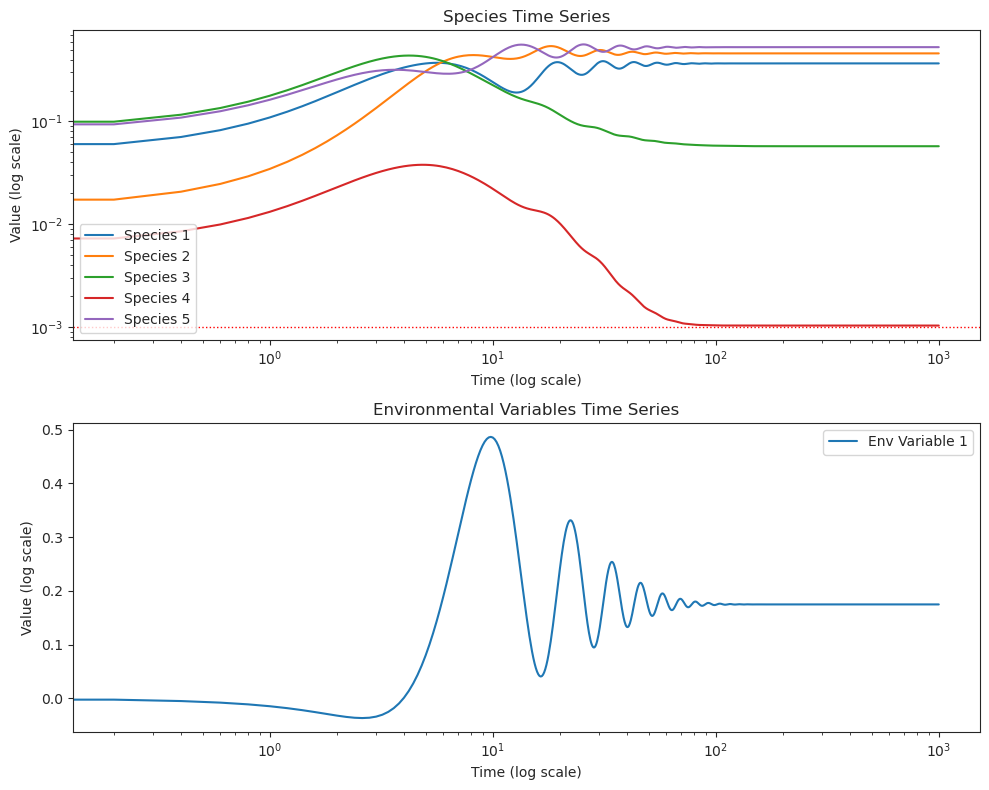

In [41]:
species_index=np.arange(1,6)
env_index=np.array([0])

y0_species=np.random.rand(5)*0.1
y0_env=[0]
t=np.linspace(0, 1000, 5000)

y_out = run_gLV_env_dynamics(y0_species, y0_env, t, system_config, species_index, env_index, to_plot=True)